<a href="https://colab.research.google.com/github/naot97/kaggle/blob/master/Sign_Language_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv("/content/drive/My Drive/sign-language-mnist/sign_mnist_train.csv")
test = pd.read_csv("/content/drive/My Drive/sign-language-mnist/sign_mnist_test.csv")

In [0]:
labels = train['label']

input = train.drop(labels=['label'],axis=1)
print(input.shape)

labels_test = test['label']
input_test  = test.drop(labels=['label'],axis=1)
print(input_test.shape)

(27455, 784)
(7172, 784)


17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

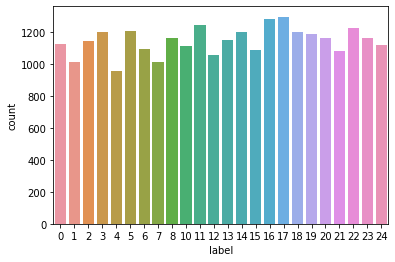

In [0]:
g = sns.countplot(labels)
labels.value_counts()

In [0]:
#
input = input/ 255.0

input = input.values.reshape((-1,28,28,1))
#input_test = input_test.values.reshape((-1,28,28,1))

print(labels)
labels = to_categorical(labels,num_classes = 25)



0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64


In [0]:
def append_element(list, list2):
  for element in list2:
    list.append(element)

  return list

In [0]:
l = np.array(labels)

X_train = []
Y_train = []
X_val = []
Y_val = []
for i in range(25):
  index = [j for j in range(len(labels)) if labels[j,i] == 1]
  n = len(index)
  if n > 10:
    x_train = input[index]
    y_train = labels[index]

    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state = 3)

    X_train = append_element(X_train, x_train)
    Y_train = append_element(Y_train,y_train)
    X_val = append_element(X_val, x_val)
    Y_val = append_element(Y_val, y_val)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

print(X_train.shape)

(24698, 28, 28, 1)


In [0]:
from keras.layers.normalization import BatchNormalization


model = Sequential()
model.add(Conv2D(filters=96,kernel_size=(5,5),padding='valid',activation='relu',strides=(2,2),input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(3,3),padding='valid',activation='relu',strides=(1,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(3,3),padding='valid',activation='relu',strides=(1,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(4096, activation = "relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(4096, activation = "relu"))      
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(25, activation = "softmax"))
model.build()
model.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 12, 12, 96)        2496      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 8, 8, 256)         221440    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 6, 6, 256)         1024      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 4, 4, 256)       

In [0]:
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.000001)
epochs = 20 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 256

In [0]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
print(X_train.shape)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

print(X_train.shape)

(24698, 28, 28, 1)
(24698, 28, 28, 1)


In [0]:

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Epoch 1/20
 - 9s - loss: 0.6858 - acc: 0.7927 - val_loss: 0.1694 - val_acc: 0.9402
Epoch 2/20
 - 6s - loss: 0.1473 - acc: 0.9513 - val_loss: 0.0303 - val_acc: 0.9891
Epoch 3/20
 - 6s - loss: 0.0835 - acc: 0.9739 - val_loss: 0.0205 - val_acc: 0.9920
Epoch 4/20
 - 6s - loss: 0.0617 - acc: 0.9813 - val_loss: 0.0061 - val_acc: 0.9982
Epoch 5/20
 - 6s - loss: 0.0437 - acc: 0.9872 - val_loss: 0.0058 - val_acc: 0.9975
Epoch 6/20
 - 6s - loss: 0.0364 - acc: 0.9883 - val_loss: 0.0016 - val_acc: 0.9996
Epoch 7/20
 - 6s - loss: 0.0252 - acc: 0.9923 - val_loss: 0.0126 - val_acc: 0.9956
Epoch 8/20
 - 6s - loss: 0.0272 - acc: 0.9919 - val_loss: 0.0278 - val_acc: 0.9913
Epoch 9/20
 - 6s - loss: 0.0262 - acc: 0.9921 - val_loss: 0.0039 - val_acc: 0.9989

Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 10/20
 - 6s - loss: 0.0070 - acc: 0.9975 - val_loss: 3.4546e-05 - val_acc: 1.0000
Epoch 11/20
 - 6s - loss: 0.0029 - acc: 0.9992 - val_loss: 1.4239e-05 - val_acc: 1.0

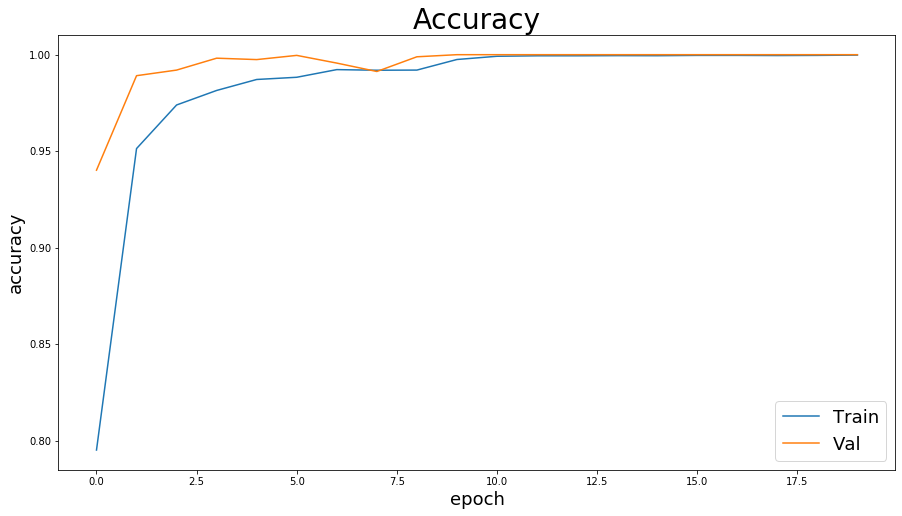

In [0]:
plt.figure(figsize=(15,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy",fontsize=28)
plt.xlabel('epoch',fontsize=18)
plt.ylabel('accuracy',fontsize=18)
plt.legend(['Train','Val'],fontsize=18)
plt.show()

In [0]:
input_test = input_test/255
input_test = input_test.values.reshape((-1,28,28,1))

y = to_categorical(labels_test, num_classes = 25)


In [0]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(input_test)
accuracy_score(y, y_pred.round())


0.9998605688789738